In [1]:
# Set up your Python workspace
# Note: The STK Python API used in this lesson is
# only available with STK 12.1.
# If not installed then use pip to install it.
# pip install agi.stk<..ver..>-py3-none-any.whl
# If using an older version of STK then use win32api or Comtypes

from agi.stk12.stkdesktop import STKDesktop
from agi.stk12.stkobjects import *
from Graph import Sensor,  Graph
from Graph_Visual import GraphVisual
import matplotlib.pyplot as plt
import random
import copy
from STK_Agent import Agent
import numpy as np

In [2]:
# When connected to STK via Python, while creating your variable, 
# using the Tab key after periods enables IntelliSense which displays 
# all of the options available off of the current interface. 
# In the next section you will start STK 

# NOTE FOR STK WEB: you can take advantage of STK/SDF SSO by changing 
# your script to connect to an active instance instead of creating a 
# new instance of STK:
# Connect to an an instance of STK12
stk = STKDesktop.AttachToApplication()

# Create a new instance of STK12.
# Optional arguments set the application visible state and the user-control 
# (whether the application remains open after exiting python).
#stk = STKDesktop.StartApplication(visible=True, userControl=True)
#Check your Task Manager to confirm that STK was called 

# Grab a handle on the STK application root.
root = stk.Root
root.UnitPreferences.Item('DateFormat').SetCurrentUnit('EpSec')

# Recall that the AGStkObjectRoot object is at the apex of the STK Object Model. 
# The associated IAgStkObjecetRoot interface will provide the methods and properties to load 
# or create new scenarios and aaccess the Object Model Unit preferences. Through app you have 
# a pointer to the IAgUiApplication interface. How will you obtain a pointer to the IAgStkObjectRoot
# interface? According to IAgUiApplication documentation, the stk.GetObjectRoot() property returns 
# a new instance of the root object of the STK Object Model. 

# Check that the root object has been built correctly, check the type()

type(root)

# output will be 
# agi.stk12.stkobjects.AgStkObjectRoot

# Now that you have launched STK via the Python interface, 
# let's see if we can create a new scenario and set the time 
# period via Python. Create a new scenario, analysis period and 
# reset the animation time.

# 1. Create a new scenario.
# The next task is to create a scenario via the NewScenario method 
# of the IAgStkObjectRoot interface. According to the documentation, 
# the NewScenario method expects to be passed a string representing 
# the name of the scenario, but does not return anything.
#root.CloseScenario()

#root.NewScenario("STK_Scenario")

scenario = root.CurrentScenario

In [3]:
# create aircraft/sensor objects with corresponding agents
aircraft = []
sensors = []

for obj in scenario.Children:
    if isinstance(obj, AgAircraft):
        aircraft.append(Agent(obj.InstanceName, obj))
    elif isinstance(obj, AgPlace):
        for sensor in obj.Children:
            sensors.append(Sensor(sensor.InstanceName, sensor))

In [4]:
# Test Access
test_sensor = sensors[0]
test_aircraft = aircraft[3]

access = test_sensor.stk_ref.GetAccessToObject(test_aircraft.stk_ref)
accessIntervals = access.ComputedAccessIntervalTimes

dataProviderElements = ['Start Time', 'Stop Time']

print(test_sensor.stk_ref.InstanceName)
print(test_aircraft.stk_ref.InstanceName)
print()

print(scenario.StartTime)
print(scenario.StopTime)
print()

for i in range(0, accessIntervals.Count):
    times = accessIntervals.GetInterval(i)
    print(times)
    print(times[0])

Sensor2
Aircraft4

0.0
30.0

(8.563, 11.144)
8.563
(24.444, 27.004)
24.444


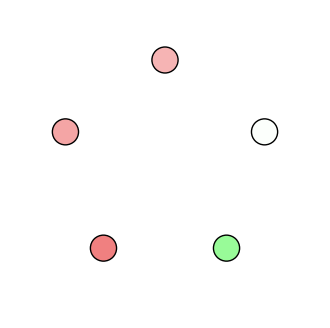

Local: [0.05069047047093451, 0.04584092522105244, 0.05253768944161007, 0.05420580601484493, 0.04918060977836576]
Actual: [0.04535871667342828, 0.04076732871615069, 0.04739178593815548, 0.04939094221349422, 0.04918060977836576]
Local: [0.07431953358925708, 0.07880364531323161, 0.09393016381693263, 0.09329484506016988, 0.03250073582413417]
Actual: [0.06960801352560556, 0.08440916484792844, 0.07842453323995854, 0.07724109816636261, 0.03250073582413417]
Local: [0.12529683433696323, 0.12466797367188573, 0.10636186133198557, 0.1624804873981952, 0.044966521710085756]
Actual: [0.0974241120825641, 0.1263629342656856, 0.10099728827050322, 0.12275890690020491, 0.044966521710085756]
Local: [0.2102412967759109, 0.24372796059484583, 0.11044625403260339, 0.18325208905440277, 0.0025117727851039066]
Actual: [0.14414899252749713, 0.19426440026201722, 0.10925614917319453, 0.16194523803371996, 0.0025117727851039066]
Local: [0.24093326756338956, 0.2921064905911279, 0.12032631534828853, 0.32906666411782604,

In [5]:
# create graph
subagents = aircraft
subagents_names = [a_i.name for a_i in subagents]
for a_i in subagents:
    a_i.init_sharing_type(subagents_names)
    a_i.init_belief(len(subagents))
subagents[-1].evil = True   

graph = GraphVisual()
graph.add_agents(subagents)

T = int(scenario.StopTime)

true_belief = (1,1,1,1,0)
graph.draw_graph(4)
plt.ion()
plt.show()
for t in range(T):
    graph.clear()
    # Loop once to update connections
    for idx, a in enumerate(graph.agents):
        agent_list = copy.copy(graph.agents)
        agent_list.pop(idx)
        
        new_vertices = {}
        for sensor in sensors:
            new_vertices.update(sensor.query(agent_list, t))
        new_vertices = list(new_vertices)
        
        graph.add_vertices(a, new_vertices)
        a.updateLocalBelief()
    # Loop again to build sharing graphs
    for idx,a in enumerate(graph.agents):
        belief_packet = dict(
            [[v_a.name, v_a.actual_belief] for v_a in graph.vertices[a]])
        a.shareBelief(belief_packet)
    local_belief = [a.local_belief[true_belief] for a in graph.agents]
    actual_belief = [a.actual_belief[true_belief] for a in graph.agents]
    print(f"Local: {local_belief}")
    print(f"Actual: {actual_belief}")
    plt.pause(1)
    graph.update_graph(actual_belief)
    plt.draw_all()
plt.ioff()
plt.show()

# Extra stuff that might be helpful

In [6]:
# Now that the scenario is fully built, the final task is to extract data and perform a basic analysis.
# You have a scenario with a Target object and a Satellite object. 
# Determine when the Satellite object can access the Target object.
# Locate and manually enter code into Python to compute an access between 
# two STK Objects using the IAgStkObject interface. 
# HINT: Review the Python Code snippits
# Or

# Enter and run the lines of code to compute access between the satellite and the target

# access = satellite.GetAccessToObject(target)
# access.ComputeAccess();

# # Retrieve and view the access data in Python.

# accessDP         = access.DataProviders.Item('Access Data')

# results          = accessDP.Exec(scenario.StartTime, scenario.StopTime)

# accessStartTimes = results.DataSets.GetDataSetByName('Start Time').GetValues()

# accessStopTimes  = results.DataSets.GetDataSetByName('Stop Time').GetValues()

# print(accessStartTimes,accessStopTimes)

In [7]:
# Note: Generating the Start & Stop times in Python can 
# also be done using the following lines of code.
# accessIntervals = access.ComputedAccessIntervalTimes

# dataProviderElements = ['Start Time', 'Stop Time']

# for i in range(0,accessIntervals.Count):
#     times = accessIntervals.GetInterval(i)
#     print(times)
#     print(times[1] - times[0])

In [8]:
# Retrieve and view the altitude of the satellite during an access interval.

# satelliteDP       = satellite.DataProviders.Item('LLA State')

# satelliteDP2      = satelliteDP.Group.Item('Fixed')

# rptElements       = ['Time', 'Lat', 'Lon', 'Alt']

# satelliteDPTimeVar = satelliteDP2.ExecElements(accessStartTimes,accessStopTimes, 60, rptElements)

# satelliteAltitude = satelliteDPTimeVar.DataSets.GetDataSetByName('Alt').GetValues()

# print(satelliteAltitude)

In [9]:
# You have just completed the STK integration with Python tutorial using Jupyter Notebooks. 
# Don't forget to save your work. 

# Note: To save your scenario you will want to create a new directory 
# and then tell python to save all the scenario files there.
# import os
# os.mkdir('Python_STK_Training')

# # This will create a new folder in your scenario directory. 
# # Open a file explorer window and copy the file path. The next 
# # line will use your custom path.

# directory = os.getcwd() + "\Python_STK_Training"
# root.ExecuteCommand('Save / * \"' + directory + '\"');

# With your scenario safely saved, you can close out of STK. 
# Workflows like these can be expanded and automated for quickly building and analyzing missions.